In [1]:
# phase1_model_training.ipynb

import os
import numpy as np
import matplotlib.pyplot as plt

# Set project directories
BASE_DIR = os.path.abspath("..")
DATA_DIR = os.path.join(BASE_DIR, "data", "raw_images")
MODEL_DIR = os.path.join(BASE_DIR, "models")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")

# Quick check
print("Data Folder Exists:", os.path.exists(DATA_DIR))

Data Folder Exists: True


In [2]:
import cv2
from glob import glob
from IPython.display import display
from PIL import Image

# Constants
IMAGE_SIZE = (256, 256)  # You can upscale later
IMAGE_FOLDER = DATA_DIR

# Step 1: Load Images in Time Series Order
def load_images(folder_path):
    image_paths = sorted(glob(os.path.join(folder_path, "*.png")))
    images = []
    years = []
    
    for path in image_paths:
        try:
            year = int(os.path.basename(path).split('_')[-1].split('.')[0])
            img = cv2.imread(path)
            img = cv2.resize(img, IMAGE_SIZE)
            images.append(img)
            years.append(year)
        except:
            continue
    return np.array(images), years

images, years = load_images(DATA_DIR)

print(f"Total Years Loaded: {len(images)}")

Total Years Loaded: 25


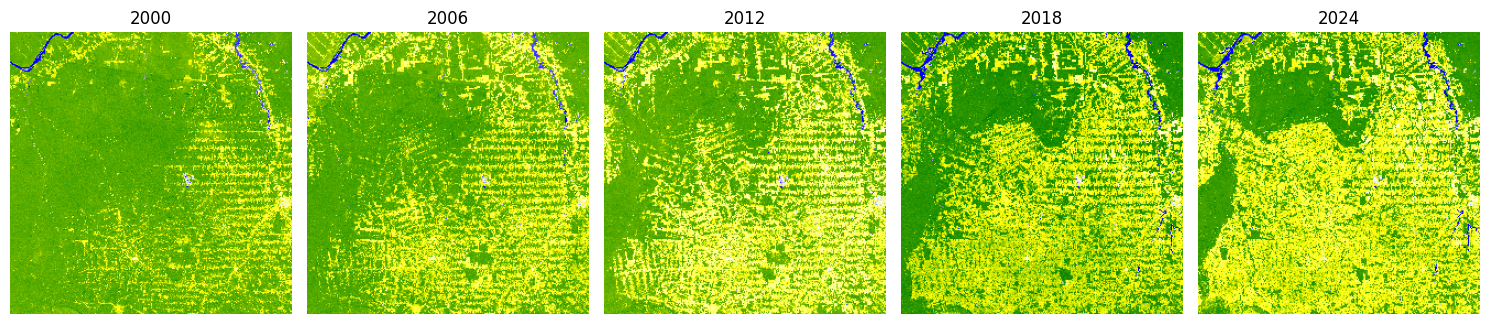

In [3]:
def plot_sample_images(images, years, step=5):
    plt.figure(figsize=(15, 5))
    for i in range(0, len(images), step):
        plt.subplot(1, len(images[::step]), i//step + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(str(years[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(images, years, step=6)  # Show one every 6 years


In [4]:
SEQUENCE_LENGTH = 5  # You can experiment with this later

def create_time_series_data(images, sequence_length):
    X, y = [], []
    for i in range(len(images) - sequence_length):
        X.append(images[i:i+sequence_length])
        y.append(images[i+sequence_length])
    return np.array(X), np.array(y)

X, y = create_time_series_data(images, SEQUENCE_LENGTH)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")


Input shape (X): (20, 5, 256, 256, 3)
Target shape (y): (20, 256, 256, 3)


In [ ]:
years = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Create time-series years data
sequence_years = [years[i:i+SEQUENCE_LENGTH] for i in range(len(years) - SEQUENCE_LENGTH)]
sequence_years = sequence_years[:len(X)]  # Align this with X after augmentations

# Now 'sequence_years' should be aligned with 'X' and ready to use
print(f"Years shape (sequence_years): {np.array(sequence_years).shape}")


Years shape (sequence_years): (20, 5)


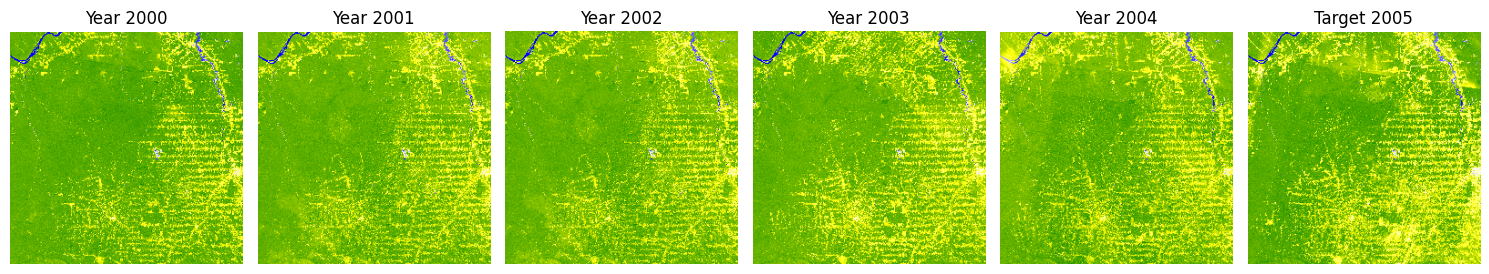

In [6]:
def plot_sequence_with_target(X, y, index=0):
    plt.figure(figsize=(15, 3))
    
    for i in range(SEQUENCE_LENGTH):
        plt.subplot(1, SEQUENCE_LENGTH + 1, i + 1)
        plt.imshow(cv2.cvtColor(X[index][i], cv2.COLOR_BGR2RGB))
        plt.title(f"Year {years[index + i]}")
        plt.axis('off')
    
    plt.subplot(1, SEQUENCE_LENGTH + 1, SEQUENCE_LENGTH + 1)
    plt.imshow(cv2.cvtColor(y[index], cv2.COLOR_BGR2RGB))
    plt.title(f"Target {years[index + SEQUENCE_LENGTH]}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sequence_with_target(X, y)


In [7]:
# Normalize inputs and outputs to [0, 1]
X = X / 255.0
y = y / 255.0


In [ ]:
def augment_data(X, y):
    X_aug = []
    y_aug = []

    for i in range(X.shape[0]):
        seq = X[i]
        target = y[i]

        # Randomly choose one operation (or none)
        operation = np.random.choice(['none', 'flip_h', 'flip_v', 'rotate', 'brightness'])

        if operation == 'flip_h':
            seq = np.flip(seq, axis=2)  # Horizontal flip (width axis)
            target = np.flip(target, axis=1)

        elif operation == 'flip_v':
            seq = np.flip(seq, axis=1)  # Vertical flip (height axis)
            target = np.flip(target, axis=0)

        elif operation == 'rotate':
            k = np.random.choice([1, 2, 3])  # 90, 180, or 270 degrees
            seq = np.rot90(seq, k=k, axes=(1, 2))
            target = np.rot90(target, k=k, axes=(0, 1))

        elif operation == 'brightness':
            brightness_factor = np.random.uniform(0.95, 1.05)  # Mild jitter only
            seq = np.clip(seq * brightness_factor, -1.0, 1.0)
            target = np.clip(target * brightness_factor, -1.0, 1.0)

        # if 'none', leave seq and target unchanged

        X_aug.append(seq)
        y_aug.append(target)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    # Concatenate original and augmented data
    X_final = np.concatenate([X, X_aug])
    y_final = np.concatenate([y, y_aug])

    return X_final, y_final

# --- Usage ---
AUGMENT = True
if AUGMENT:
    X_augmented, y_augmented = augment_data(X, y)

    # Update sequence years too if needed
    repeat_factor = X_augmented.shape[0] // X.shape[0]
    
    print("Original X shape:", X.shape)
    print("Augmented X shape:", X_augmented.shape)
    print("Repeat factor:", repeat_factor)



Original X shape: (20, 5, 256, 256, 3)
Augmented X shape: (40, 5, 256, 256, 3)
Repeat factor: 2


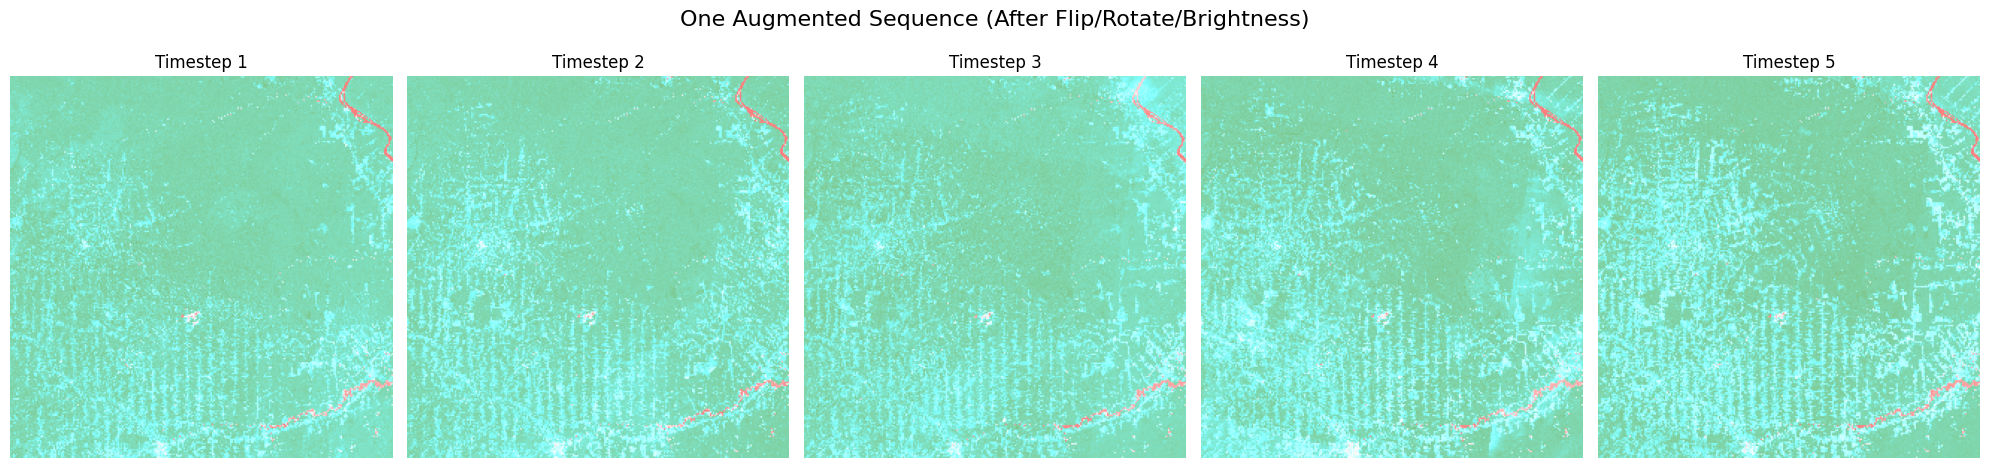

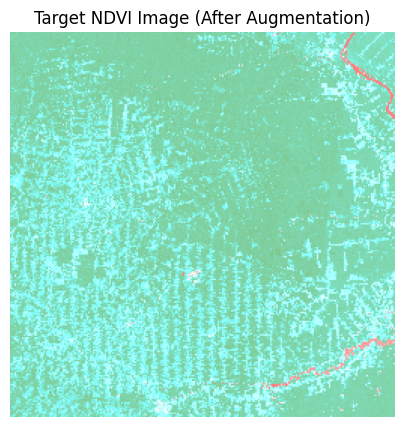

In [9]:
# Pick the first sequence (you can change index)
sample_seq = X_augmented[22]  # shape: (seq_len, H, W, C)
sample_target = y_augmented[22]

# Plot all timesteps in the sequence
fig, axes = plt.subplots(1, sample_seq.shape[0], figsize=(20, 5))

for i in range(sample_seq.shape[0]):
    axes[i].imshow((sample_seq[i] + 1) / 2, cmap='gray')  # Use cmap='gray' for grayscale images
    axes[i].axis('off')
    axes[i].set_title(f"Timestep {i+1}")

plt.suptitle("One Augmented Sequence (After Flip/Rotate/Brightness)", fontsize=16)
plt.tight_layout()
plt.show()

# Plot target image too
plt.figure(figsize=(5, 5))
plt.imshow((sample_target + 1) / 2, cmap='viridis')  
plt.title("Target NDVI Image (After Augmentation)")
plt.axis('off')
plt.show()


In [10]:
# Get how many times the original data was expanded by augmentation
repeat_factor = X_augmented.shape[0] // X.shape[0]

# Now tile/replicate based on the repeat_factor
sequence_years_augmented = sequence_years * repeat_factor

print("Original X shape:", X.shape)
print("Augmented X shape:", X_augmented.shape)
print("Repeat factor:", repeat_factor)
print("Augmented Years shape:", np.shape(sequence_years_augmented))  # should match X_augmented.shape[0]


Original X shape: (20, 5, 256, 256, 3)
Augmented X shape: (40, 5, 256, 256, 3)
Repeat factor: 2
Augmented Years shape: (40, 5)
